In [38]:
%load_ext autoreload
%autoreload 2

from model.autoregressive import ARModel
from model.lorenz96 import Lorenz96
from model.parameter import Parameter
from filtering.colkf import ColKF
from filtering.enkf import EnKF
from utils import default_generator
from utils.plotter import Plotter
from utils.compare import Comparator

import numpy as np
import matplotlib.pyplot as plt

Plotter.fig_folder = "results_L96"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
generator = default_generator
F = 8.0
forcing = Parameter(init_value=F, uncertainty=0.05, name="$F$", estimate=True)
D = 20

dt = 0.05
T0 = 0
T = 20
N = 40

x0_unperturbed = generator.normal(size=D)
x0 = x0_unperturbed.copy()
x0 += 0.001

Q_0 = 0.01 * np.eye(D)
Q_x = lambda _: 0.01 * np.eye(D)
R = lambda _: 0.2 * np.eye(D)

b0 = np.zeros(D)
b0_cov = 0.01 * np.eye(D)
Q_b = lambda _: 0.0001 * np.eye(D)
b_true = 5 * np.ones(D)

H = lambda _: np.eye(D)

model = Lorenz96(
    x0_unperturbed,
    dt,
    D,
    forcing,
    H,
    Q_x,
    R,
    generator,
    solver="rk4",
    stochastic_integration=False,
    stochastic_propagation=False,
)

model.offset = lambda t, state: b_true
times, states = model.integrate(T0, T)
model.reset_model(x0)

# Generate observations with noise
assimilation_step = 0.5
assimilation_times = np.linspace(assimilation_step, T, int(T / assimilation_step))
observed = np.zeros((D, len(assimilation_times)))
for i, t in enumerate(assimilation_times):
    k = int(t / dt)
    observed[:, i] = model.observe(states[:, k], add_noise=True)

In [40]:
model.offset = lambda *_: np.zeros(D)
model.stochastic_integration = True
# perturbed_parameter = F - 0.1
perturbed_parameter = F
model.uncertain_parameters = [perturbed_parameter]
for param in model.uncertain_parameters:
    param.init_value = perturbed_parameter

enkf = EnKF(model, x0, Q_0, N, generator=generator)
results = enkf.filter(assimilation_times, observed)
results.true_times = times
results.true_states = states
results.figsize = "horizontal"

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:03<00:00, 12.26it/s]


In [41]:
A = lambda _: np.diag([1] * D)
H_ar = lambda _: np.zeros((0, b0.shape[0]))

ar_model = ARModel(
    A,
    H_ar,
    b0,
    dt,
    Q_b,
    generator,
    stochastic_propagation=False,
    stochastic_integration=False,
)
colkf = ColKF(ar_model, enkf, x0, Q_0, b0, b0_cov, feedback=True)
results_col = colkf.filter(assimilation_times, observed)
results_col.figsize = "horizontal"

100%|██████████| 40/40 [00:04<00:00,  9.17it/s]


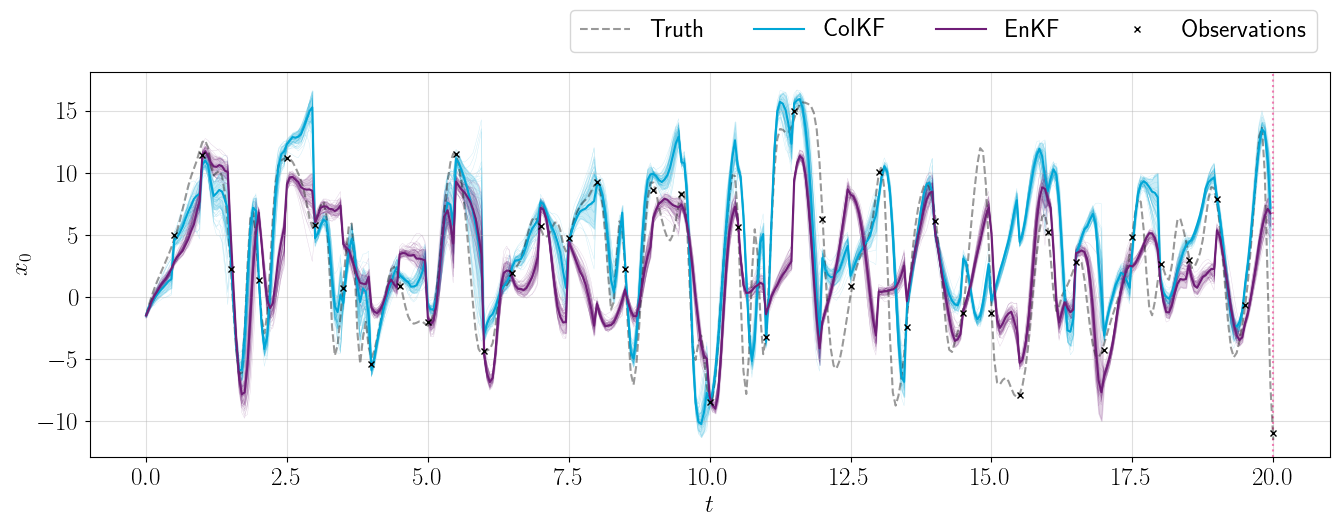

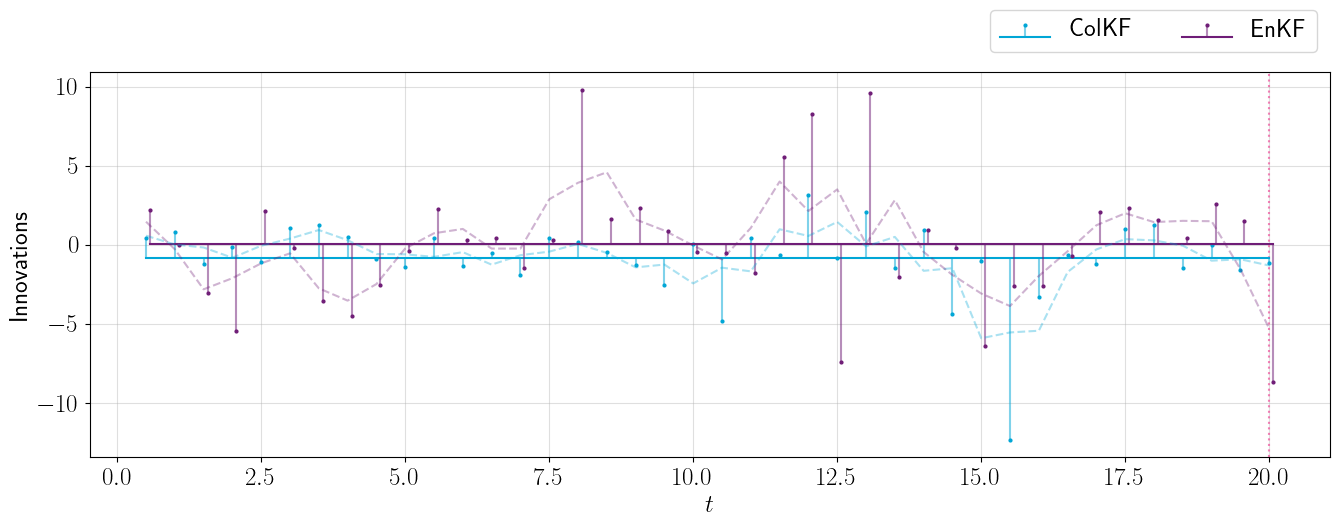

In [42]:
c = Comparator([results_col, results], ["ColKF", "EnKF"])

idxs = [0, 5, 10]
idxs = [0]
for i in idxs:
    c.compare_filtering(
        state_idx=i,
        plot_ensemble=True,
        plot_bands=True,
        figsize="horizontal",
        path=f"compare_x{i}",
    )
    c.compare_innovations(
        state_idx=i, figsize="horizontal", window=3, path=f"compare_inn_x{i}"
    )
plt.show()
# plt.close("all")

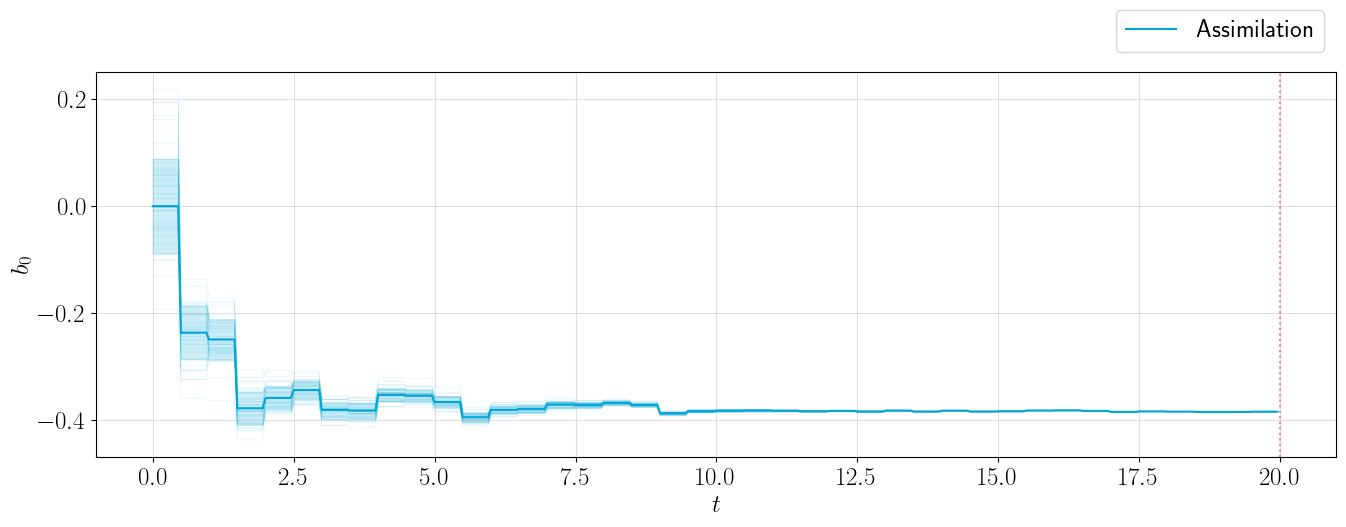

In [43]:
for i in [s + D for s in idxs]:
    results_col.plot_filtering(i, True, True, path=f"bias_ar{i-2}", only_state=True)

<Axes: xlabel='Average innovations per state', ylabel='Frequency'>

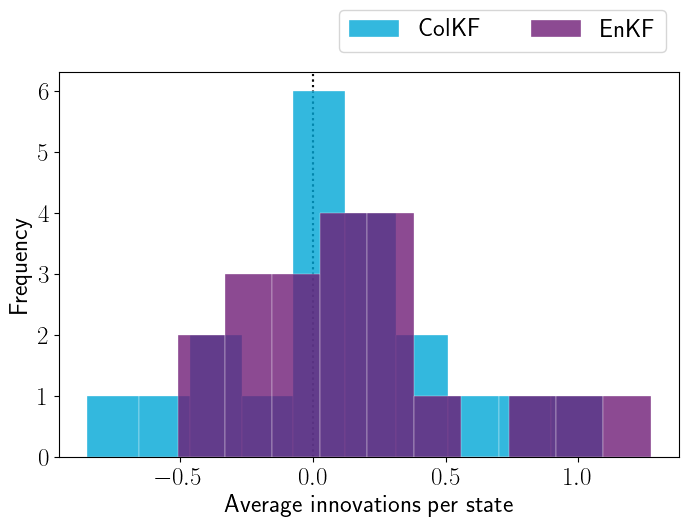

In [44]:
c.compare_av_innovations(alpha=0.8)

In [45]:
if forcing.estimate:
    c.compare_params([0], ref_params=[F])
    # ax = results.plot_params([0], [F])
    # results_col.plot_params([0], [F], ax=ax)

In [46]:
if forcing.estimate:
    F_bounds = [F - 3 * forcing.uncertainty, F + 3 * forcing.uncertainty]
    b_bounds = [8 - f for f in F_bounds]

    _, ax = Plotter.subplots(1, 1, "standard")

    plt.plot(b_bounds, F_bounds, "k:")
    plt.plot(0, 8, "ko")
    plt.xlabel("$b$")
    plt.ylabel("$F$")

    for i in range(D):
        plt.scatter(
            results_col.estimated_states[D + i, :],
            results_col.estimated_params.squeeze(),
            c=results_col.assimilation_times,
            s=2,
        )
    plt.colorbar()